In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import riskfolio as rp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# Liste des actifs
assets = ['SPY', 'VWRD.L', 'C40.PA', 'EXS1.DE', 'EWU', 'EWJ', 'AAPL', 'TSLA']

# Télécharger les données
data = yf.download(assets, start='2018-01-01', end='2024-01-01', period='1d')['Adj Close']

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Calcul des rendements simples et de la matrice de covariance
simple_returns = data.dropna().pct_change()
mean_simple_returns = simple_returns.mean() * 252
cov_matrix_simple_returns = simple_returns.cov() * 252

In [4]:
# Fonction de performance du portefeuille
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

# Fonction de ratio de Sharpe
def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_returns, p_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return (p_returns - risk_free_rate) / p_risk

# Fonction de pour minimiser le risque
def minimize_risk(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

In [5]:
# impose que la somme des poids (x) doit être égale à 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# chaque poids est contraint entre 0 et 1
bounds = tuple((0, 1) for _ in range(len(assets)))

# minimisation
result = minimize(
    minimize_risk, 
    len(assets) * [1. / len(assets),], 
    args=(mean_simple_returns, cov_matrix_simple_returns), 
    method='SLSQP', 
    bounds=bounds, 
    constraints=constraints
    )

# resultats
weights = result.x
print("Poids optimaux pour chaque actif (Mean-Variance Optimization):")
for asset, weight in zip(assets, weights):
    print(f"{asset}: {weight:.2%}")

Poids optimaux pour chaque actif (Mean-Variance Optimization):
SPY: 0.00%
VWRD.L: 1.85%
C40.PA: 48.90%
EXS1.DE: 0.00%
EWU: 0.00%
EWJ: 0.91%
AAPL: 0.00%
TSLA: 48.34%


In [6]:
# Générer des portefeuilles aléatoires
num_portfolios = 100000
results = np.zeros((num_portfolios, 3))  # Pour les rendements, risques et Sharpe ratios
weights_record = np.zeros((num_portfolios, len(assets)))  # Pour les poids

for i in range(num_portfolios):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)
    weights_record[i, :] = weights
    portfolio_return, portfolio_risk = portfolio_performance(weights, mean_simple_returns, cov_matrix_simple_returns)
    results[i, 0] = portfolio_return
    results[i, 1] = portfolio_risk
    results[i, 2] = sharpe_ratio(weights, mean_simple_returns, cov_matrix_simple_returns)
    
# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results, columns=['Return', 'Risk', 'Sharpe'])
weights_df = pd.DataFrame(weights_record, columns=assets)

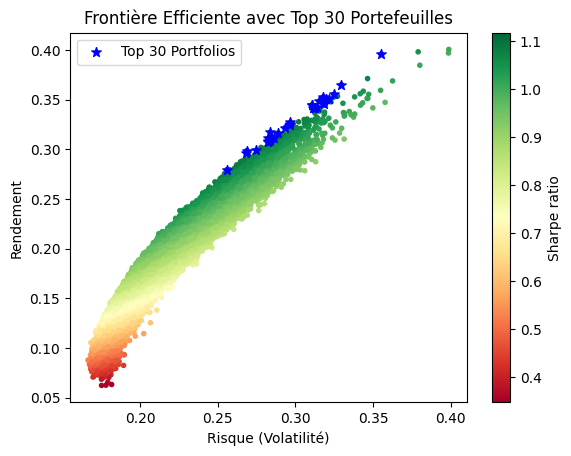

In [7]:
# Trouver les 30 meilleurs portefeuilles selon le ratio de Sharpe
top_ptf_number = 30
top_portfolios = results_df.nlargest(top_ptf_number, 'Sharpe').reset_index(drop=True)

# Visualisation de la frontière efficiente et des top portefeuilles
plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe'], cmap='RdYlGn', marker='.')
plt.colorbar(label='Sharpe ratio')
plt.scatter(top_portfolios['Risk'], top_portfolios['Return'], color='blue', marker='*', s=50, label=f'Top {top_ptf_number} Portfolios')
plt.xlabel('Risque (Volatilité)')
plt.ylabel('Rendement')
plt.title(f'Frontière Efficiente avec Top {top_ptf_number} Portefeuilles')
plt.legend()
plt.show()

In [8]:
assets = ['VWRD.L', 'C40.PA', 'EWJ', 'TSLA', 'BTC-USD', 'ETH-USD']
assets = ['SPY', 'VWRD.L', 'C40.PA', 'EXS1.DE', 'EWU', 'EWJ', 'AAPL', 'TSLA']
data = yf.download(assets, start='2018-01-01', end='2024-01-01', interval='1d')['Adj Close']

[*********************100%%**********************]  8 of 8 completed


C:\Users\trist\AppData\Local\Temp\ipykernel_36156\553294679.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Poids optimaux pour chaque actif en % :
         AAPL  C40.PA   EWJ    EWU  EXS1.DE    SPY  TSLA  VWRD.L
weights  8.02   12.66  18.4  13.99    11.82  14.75  1.98   18.38


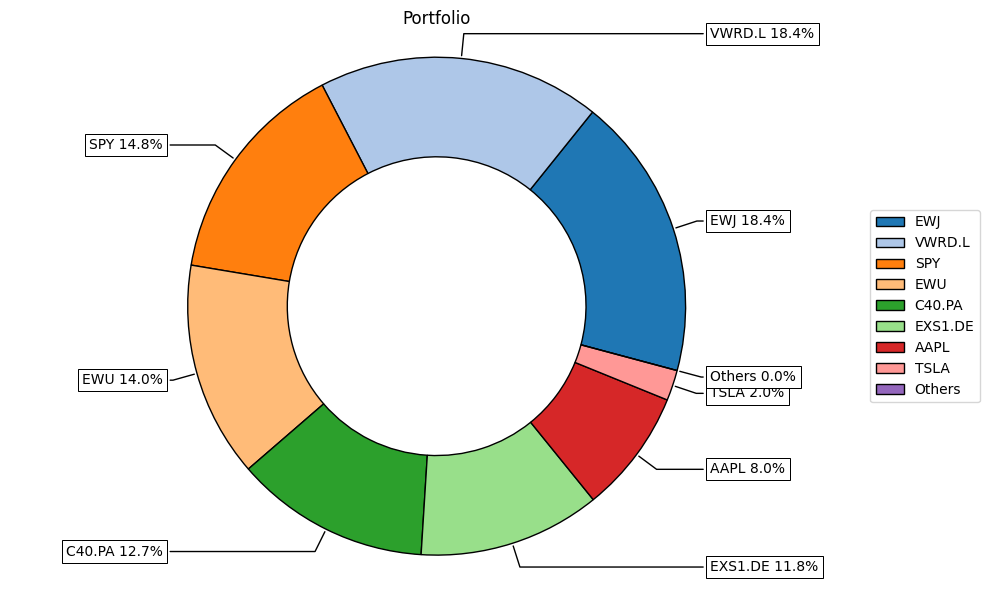

In [9]:
# methode Parité de Risque Hiérarchique
returns = data.pct_change().dropna()
port = rp.HCPortfolio(returns=returns)
w = port.optimization(model='HRP', rm='MV', obj='MinRisk')

# affichage des resultats
print("Poids optimaux pour chaque actif en % :")
print(round(w.T*100,2))
ax = rp.plot_pie(w=w, title='Portfolio', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)